In [58]:
%matplotlib notebook
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
import spike_utils as su
import json
from datetime import date
import importlib
import math
from random import seed,randrange
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections as mc
from matplotlib.collections import LineCollection
from matplotlib.colors import colorConverter
import matplotlib.gridspec as gridspec
import h5py

# Global functions

In [59]:
def load_spk(spkf):
    dat = np.loadtxt(spkf)
    spt = [x[0] for x in dat] if dat[-1][0]<1000 else [x[0]/1000 for x in dat] # convert to second if necessary
    spe = [int(x[1]) for x in dat] # electrodes
    return spt,spe

In [60]:
def zoom_ib(ib):
    global spt
    global bs
    global dr
    i = 0
    i0 = 0
    while i<len(spt) and spt[i]<bs[ib]-0.2:
        i0 = i
        i += 1
    i1 = i
    while i<len(spt) and spt[i]<dr[ib]+0.4:
        i += 1
        i1 = i
    return i0,i1

In [61]:
def zoom0_ib(ib):
    global spt
    global bs
    global dr
    i = 0
    i0 = 0
    while i<len(spt) and spt[i]<bs[ib]:
        i0 = i
        i += 1
    i1 = i
    while i<len(spt) and spt[i]<dr[ib]:
        i += 1
        i1 = i
    return i0,i1

In [62]:
def prob_val(v,i,j):
    global spt
    global spe
    global e2p
    global tau
    x0 = e2p[spe[j]]
    t0 = spt[j]
    pr = 0
    nm = 0
    while i<j:
        dx = x0-e2p[spe[i]]
        dt = t0-spt[i]
        if dt==0: break
        r2 = sum(dx*dx)
        if r2>0:
            vt = v*dt
            vt2 = vt*vt
            pr += math.exp(-dt/tau-r2/vt2)/vt2
            nm += math.exp(-dt/tau)
        i += 1
    return pr/nm if nm > 0 else 0
def prob_srg(v,i,j):
    global spt
    global rde
    global e2p
    global tau
    x0 = e2p[rde[j]]
    t0 = spt[j]
    pr = 0
    nm = 0
    while i<j:
        dx = x0-e2p[rde[i]]
        dt = t0-spt[i]
        if dt==0: break
        r2 = sum(dx*dx)
        if r2>0:
            vt = v*dt
            vt2 = vt*vt
            pr += math.exp(-dt/tau-r2/vt2)/vt2
            nm += math.exp(-dt/tau)
        i += 1
    return pr/nm if nm>0 else 0
def proprob(v,ib): # predictability within a burst
    global spt
    global tau
    global bs
    global dr
    mtau = 2*tau
    i = 0
    while i<len(spt) and spt[i]<bs[ib]-mtau: i += 1
    j = i
    while j<len(spt) and spt[j]<bs[ib]: j += 1
    lvt = []
    lvv = []
    lvs = []
    while j<len(spt) and spt[j]<dr[ib]:
        while i<j-1 and spt[i]<spt[j]-mtau: i += 1
        p = prob_val(v,i,j)
        s = prob_srg(v,i,j)
        lvt.append(spt[j])
        lvv.append(p)
        lvs.append(s)
        j += 1
    return lvt,lvv,lvs
def proprob_all(v): # predictibility for entire recording
    global tau
    global spt
    global bs
    global dr
    mtau = 2*tau
    i = 0
    while i<len(spt) and spt[i]<bs[0]-mtau: i += 1
    j = i
    while j<len(spt) and spt[j]<bs[0]: j += 1
    lvt = []
    lvv = []
    lvs = []
    while j<len(spt) and spt[j]<dr[-1]:
        while i<j-1 and spt[i]<spt[j]-mtau: i += 1
        p = prob_val(v,i,j)
        s = prob_srg(v,i,j)
        lvt.append(spt[j])
        lvv.append(p)
        lvs.append(s)
        j += 1
    return lvt,lvv,lvs

In [63]:
# calculate center of activity trajectory (CAT)
def slide_cat(i0,i1,win):
    global spt
    global spe
    global e2p
    cat = []
    ca = []
    cac = []
    j0 = i0
    j1 = i0
    ct = 0
    tx = np.array([0.0,0.0])
    while j0<i1:
        if j1<=i1 and spt[j1]<spt[j0]+win:
            t = spt[j1]-win/2
            x = e2p[spe[j1]]
            c = j1-j0+0.5
            if c>2:
                cat.append(t)
                ca.append((tx+0.5*x)/c)
                cac.append(c)
            j1 += 1
            tx += x
        else:
            t = spt[j0]+win/2
            x = e2p[spe[j0]]
            c = j1-j0-0.5
            if c>2:
                cat.append(t)
                ca.append((tx-0.5*x)/c)
                cac.append(c)
            j0 += 1
            tx -= x
    return cat,ca,cac

In [64]:
def find_range(xs,x0,x1):
    i0 = 0
    while i0+1<len(xs) and xs[i0+1]<x0: i0 += 1
    i1 = 0
    while i1<len(xs) and xs[i1]<=x1: i1 += 1
    return i0,i1

## Experimental Data: Culture C 33 DIV
optimal $v$ is 2500

In [65]:
# load experimental data
dExp = {}
spkf = 'C33.spk'
tau=0.005
vopt = 2500
ib = 22 # representative burst
spt,spe = load_spk(spkf)
seed(54321) # make reproducible
rde = [randrange(4096) for i in spe] # random-electrode surrogate
e2p = [np.array([x%64,x//64]) for x in range(4096)]
hst,cnt = su.slide_hist(spt,0.1)
[bs,dr] = su.hst_burst(hst,cnt,tau=1.5)

In [66]:
# determine optimal v
ibn = 'C33vopt'
try:
    ppv,ppg,pps = np.load('cache/'+ibn+'.npy')
except Exception as e:
    ppv = np.array([])
    ppg = np.array([])
    pps = np.array([])
for v in np.arange(700,4000,64): # calculate additional v values
    if v in ppv: continue
    print(v)
    lvt,lvv,lvs = proprob_all(v)
    ppv = np.append(ppv,v)
    ppg = np.append(ppg,np.mean(lvv))
    pps = np.append(pps,np.mean(lvs))
    ii = ppv.argsort()
    ppg = ppg[ii]
    pps = pps[ii]
    ppv = ppv[ii]
    np.save('cache/'+ibn,[ppv,ppg,pps]) # save calculation results to cache
dExp['predV'] = [ppv,ppg-pps] 

In [67]:
# zoom in the specific burst
i0,i1 = zoom_ib(ib)
hst,cnt = su.slide_hist(spt[i0:i1],0.01)
pkt,pkh,pks,pke = su.hst_peaks1(hst,cnt,epsilon=0.02) # peak dection
pkh = np.array(pkh)
ii = pkh>0.1*np.max(pkh) # filter out in significant peaks
pkt = np.array(pkt)[ii]
pkh = np.array(pkh)[ii]
pks = np.array(pks)[ii]
pke = np.array(pke)[ii]
cnt = np.array(cnt)
srt = [x/0.01/1000 for x in cnt]

In [68]:
rspexp = [i0,i1,spt,spe,hst,srt]

<IPython.core.display.Javascript object>


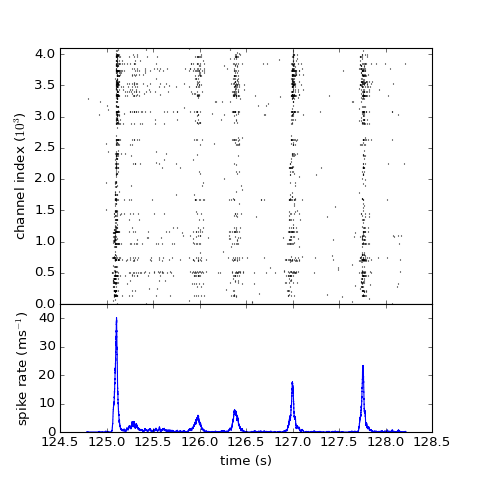

In [69]:
f = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(2,1,height_ratios=[2,1])
a = f.add_subplot(gs[0])
a.vlines(spt[i0:i1],np.array(spe[i0:i1])/1000.0,(np.array(spe[i0:i1])+8)/1000.0)
a.set_xlim([spt[i0],spt[i1]])
a.set_ylim([0,4.096])
a.set_ylabel(r'channel index ($10^3$)')
plt.setp(a.get_xticklabels(),visible=False)
a = f.add_subplot(gs[1],sharex=a)
a.plot(hst,srt)
a.set_yticks([0,10,20,30,40])
a.set_ylabel(r'spike rate (ms$^{-1}$)')
a.set_xlabel(r'time (s)')
f.subplots_adjust(hspace=0)
#f.savefig('exp_raster.svg',transparent=True,bbox_inches='tight')
plt.show()

In [70]:
# calculate CAT
cat,ca,cac = slide_cat(i0,i1,0.01)
pcats = []
s = 0
a = False
for i in range(len(cat)):
    if cat[i]<pks[s]: continue
    if cat[i]<=pke[s]:
        if a:
            sgms.append([pt,ca[i]])
            lwds.append(np.log(cac[i-1]+cac[i])/2)
        else:
            sgms = []
            lwds = []
            a = True
        pt = ca[i]
        continue
    if a:
        pcats.append([sgms,lwds])
        a = False
        s += 1
        if s>=len(pks): break

In [71]:
# calculate predictibility
lvt,lvv,lvs = proprob(vopt,ib)
hstv,cntv = su.slide_hist([lvt[i] for i in range(len(lvv)) if lvv[i]>2.0/4096],0.01)

In [72]:
dExp['hstt'] = [hst,cnt/10]
dExp['hpks'] = []
j0 = 0
k0 = i0
l0 = 0
for i in range(len(pkt)):
    while hst[j0]<pks[i]: j0 += 1
    j1 = j0
    while hst[j1]<pke[i]: j1 += 1
    while spt[k0]<pks[i]: k0 += 1
    k1 = k0
    while k1<i1 and spt[k1]<pke[i]: k1 += 1
    while lvt[l0]<pks[i]: l0 += 1
    l1 = l0
    while l1<len(lvt) and lvt[l1]<pke[i]: l1 += 1
    cttl = k1-k0
    covt = len([1 for x in lvv[l0:l1] if x>0.0005])
    dExp['hpks'].append([j0-1,j1,cttl,covt,[pkt[i],pkh[i],pks[i],pke[i]]])
    j0 = j1
    k0 = k1
    l0 = l1

In [73]:
# for all peaks in all bursts
pkst = []
pksf = []
pksk = []
for ib in range(len(bs)):
    lvt,lvv,lvs = proprob(vopt,ib)
    i0,i1 = zoom_ib(ib)
    hst,cnt = su.slide_hist(spt[i0:i1],0.01)
    pkt,pkh,pks,pke = su.hst_peaks1(hst,cnt,epsilon=0.02)
    ii=pkh>0.1*np.max(pkh) # filter our insignificant peaks
    pkt = np.array(pkt)[ii]
    pkh = np.array(pkh)[ii]
    pks = np.array(pks)[ii]
    pke = np.array(pke)[ii]
    pkf = [] # fraction
    pkk = [] # synchrony
    l0 = 0
    for i in range(len(pkt)):
        while lvt[l0]<pks[i]: l0 += 1
        l1 = l0
        while lvt[l1]<pke[i]: l1 += 1
        cttl = l1-l0
        covt = len([1 for x in lvv[l0:l1] if x>0.0005])
        pkf.append(covt/cttl)
        pkk.append(pkh[i]/cttl)
        l0 = l1
    pkst.append(pkt-pks[0])
    pksf.append(pkf)
    pksk.append(pkk)
dExp['allp'] = [pkst,pksf,pksk]

## Simulation: tpks2 0X

In [74]:
dSim = {}
spkf = "d_0X.spk"
vopt = 154.3
ib=27
tau=0.001
spt,spe = load_spk(spkf)
seed(54321) # make reproducible
rde = [randrange(256) for i in spt]
hst,cnt = su.slide_hist(spt,0.1)
[bs,dr] = su.hst_burst(hst,cnt)

In [75]:
fd = h5py.File('d_0X.h5','r')
e2p = np.array([[x['x'],x['y']] for x in fd['neurons']])
ldts = [[tuple(e2p[x['from']]),tuple(e2p[x['to']])] for x in fd['synapses']]
xs,yx=zip(*e2p)
fd.close()

<IPython.core.display.Javascript object>


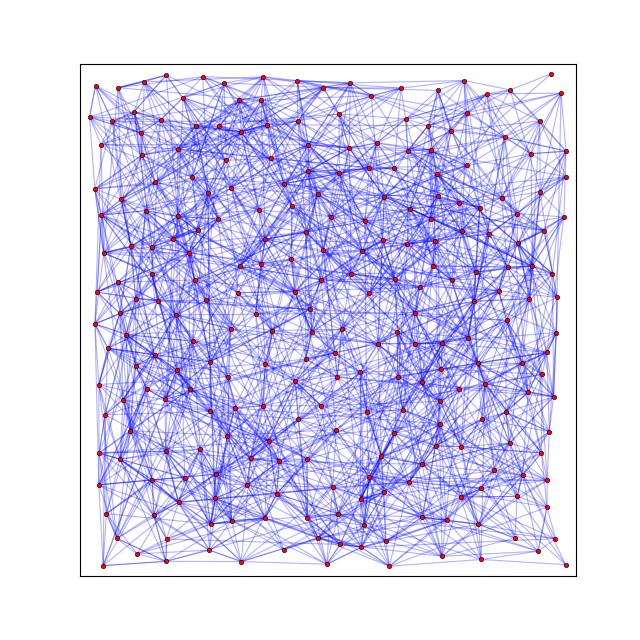

In [76]:
f,a = plt.subplots(figsize=(8,8))
lc = mpl.collections.LineCollection(ldts,color=(0,0,1,0.3))
a.add_collection(lc)
a.autoscale()
a.margins(0.02)
a.plot(xs,yx,'ro',markersize=4)
a.set_xticks([])
a.set_yticks([])
#plt.savefig('tpks2_net.svg',transparent=True,bbox_inches='tight')
plt.show()

In [77]:
# find best v
ibn = 'tpks2-0X'
try:
    ppv,ppg,pps = np.load('cache/'+ibn+'.npy')
except Exception as e:
    ppv = np.array([])
    ppg = np.array([])
    pps = np.array([])
for v in np.arange(95,220,1): # calculate additional v values
    if v in ppv: continue
    print(v)
    lvt,lvv,lvs = proprob_all(v)
    ppv = np.append(ppv,v)
    ppg = np.append(ppg,np.mean(lvv))
    pps = np.append(pps,np.mean(lvs))
    ii = ppv.argsort()
    ppg = ppg[ii]
    pps = pps[ii]
    ppv = ppv[ii]
    np.save('cache/'+ibn,[ppv,ppg,pps]) # save calculation results to cache
dSim['predV'] = [ppv,ppg-pps]

In [78]:
i0,i1 = zoom_ib(ib)
hst,cnt = su.slide_hist(spt[i0:i1],0.01)
lvt,lvv,lvs = proprob(vopt,ib)
hstv,cntv = su.slide_hist([lvt[i] for i in range(len(lvv)) if lvv[i]>2.0],0.01)
pkt,pkh,pks,pke = su.hst_peaks2(hst,cnt,epsilon=0.02)
cnt = np.array(cnt)
srt = [x/0.01/1000 for x in cnt]

In [79]:
rspsim = [i0,i1,spt,spe,hst,srt]

<IPython.core.display.Javascript object>


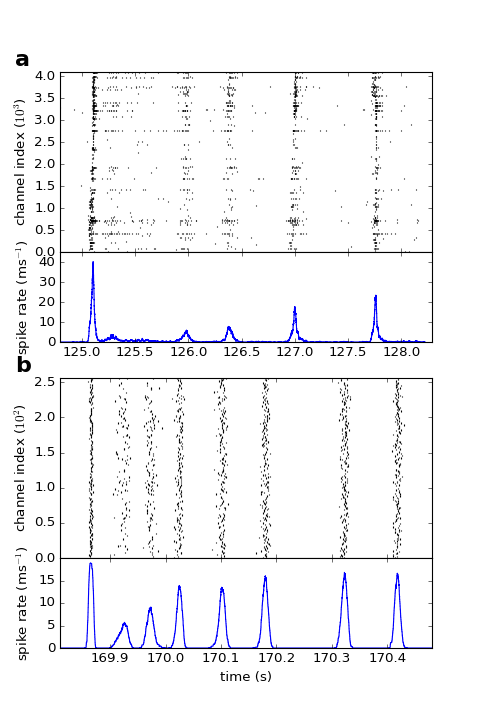

In [80]:
[i0,i1,spt,spe,hst,srt] = rspexp
f = plt.figure(figsize=(6,9))
gs = gridspec.GridSpec(3,1,height_ratios=[2,1,3.4])
a = f.add_subplot(gs[0])
a.vlines(spt[i0:i1],np.array(spe[i0:i1])/1000.0,(np.array(spe[i0:i1])+8)/1000.0)
a.set_ylim([0,4.096])
a.set_ylabel(r'channel index ($10^3$)')
a.set_title('a',position=(-0.1,1),fontsize=20,fontweight='bold')
plt.setp(a.get_xticklabels(),visible=False)
a = f.add_subplot(gs[1],sharex=a)
a.plot(hst,srt)
a.set_yticks([0,10,20,30,40])
a.set_ylabel(r'spike rate (ms$^{-1}$)')
a.set_xlim([spt[i0],spt[i1]])
f.subplots_adjust(hspace=0)

[i0,i1,spt,spe,hst,srt] = rspsim
s0,s1 = find_range(spt,bs[ib]-0.0,dr[ib]-0.0)
srt = [x/0.01/1000 for x in cnt]
gs = gridspec.GridSpec(3,1,height_ratios=[3.4,2,1])
a = f.add_subplot(gs[1])
a.vlines(spt[s0:s1],np.array(spe[s0:s1])/100.0,(np.array(spe[s0:s1])+2)/100.0)
a.set_ylim([0,2.56])
a.set_ylabel(r'channel index ($10^2$)')
a.set_title('b',position=(-0.1,1),fontsize=20,fontweight='bold')
plt.setp(a.get_xticklabels(),visible=False)
a = f.add_subplot(gs[2],sharex=a)
a.plot(hst,srt)
a.set_ylabel(r'spike rate (ms$^{-1}$)')
a.set_xlabel(r'time (s)')
a.ticklabel_format(useOffset=False)
a.set_yticklabels([0,5,10,15])
a.set_xlim([spt[s0+1]-0.05,spt[s1-1]+0.05])
f.subplots_adjust(hspace=0)
#f.savefig('both_raster.svg',transparent=True,bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


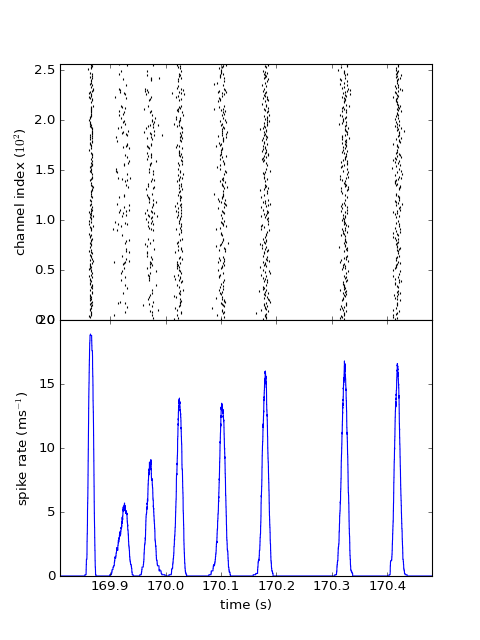

In [81]:
[i0,i1,spt,spe,hst,srt] = rspsim
s0,s1 = find_range(spt,bs[ib]-0.0,dr[ib]-0.0)
srt = [x/0.01/1000 for x in cnt]
f,a = plt.subplots(2,sharex=True,figsize=(6,8))
a[0].vlines(spt[s0:s1],np.array(spe[s0:s1])/100.0,(np.array(spe[s0:s1])+2)/100.0)
a[0].set_xlim([spt[s0+1]-0.05,spt[s1-1]+0.05])
a[0].set_ylim([0,2.56])
a[0].set_ylabel(r'channel index ($10^2$)')
a[1].plot(hst,srt)
a[1].set_ylabel(r'spike rate (ms$^{-1}$)')
a[1].set_xlabel(r'time (s)')
a[1].ticklabel_format(useOffset=False)
f.subplots_adjust(hspace=0)
#f.savefig('sim_raster.svg',transparent=True,bbox_inches='tight')
plt.show()

In [82]:
dSim['hstt'] = [hst,cnt/10]
s0,s1 = find_range(hst,bs[ib]-0.0,dr[ib]-0.0)
dSim['hstt'] = ([hst[s0+1:s1],(cnt/10)[s0+1:s1]])
dSim['hpks'] = []
j0 = 0
k0 = i0
l0 = 0
for i in range(len(pkt)):
    while hst[j0]<pks[i]: j0 += 1
    j1 = j0
    while hst[j1]<pke[i]: j1 += 1
    while spt[k0]<pks[i]: k0 += 1
    k1 = k0
    while k1<i1 and spt[k1]<pke[i]: k1 += 1
    while lvt[l0]<pks[i]: l0 += 1
    l1 = l0
    while l1<len(lvt) and lvt[l1]<pke[i]: l1 += 1
    cttl = k1-k0
    covt = len([1 for x in lvv[l0:l1] if x>2])
    dSim['hpks'].append([j0-1,j1,cttl,covt,[pkt[i],pkh[i],pks[i],pke[i]]])
    j0 = j1
    k0 = k1
    l0 = l1

In [83]:
pkst = []
pksf = []
pksk = []
for ib in range(len(bs)):
    lvt,lvv,lvs = proprob(vopt,ib)
    i0,i1 = zoom_ib(ib)
    hst,cnt = su.slide_hist(spt[i0:i1],0.01)
    pkt,pkh,pks,pke = su.hst_peaks2(hst,cnt,epsilon=0.02)
    ii=pkh>0.1*np.max(pkh) # filter out insignificant peaks
    pkt = np.array(pkt)[ii]
    pkh = np.array(pkh)[ii]
    pks = np.array(pks)[ii]
    pke = np.array(pke)[ii]
    pkf = []
    pkk = []
    l0 = 0
    for i in range(len(pkt)):
        while lvt[l0]<pks[i]: l0 += 1
        l1 = l0
        while l1<len(lvt) and lvt[l1]<pke[i]: l1 += 1
        cttl = l1-l0
        covt = len([1 for x in lvv[l0:l1] if x>2])
        pkf.append(covt/cttl)
        pkk.append(pkh[i]/cttl)
        l0 = l1
    pkst.append(pkt-pks[0])
    pksf.append(pkf)
    pksk.append(pkk)
dSim['allp'] = [pkst,pksf,pksk]

## Figure plot

<IPython.core.display.Javascript object>


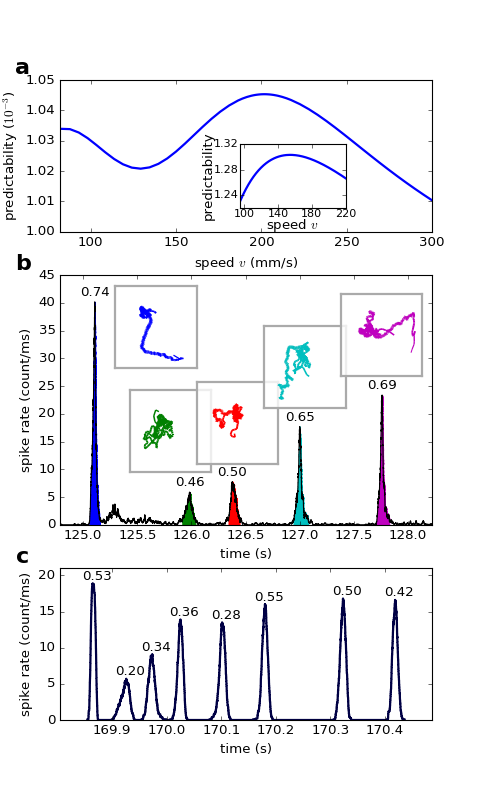

In [84]:
f = plt.figure(figsize=(6,10))
gs = gridspec.GridSpec(7,1)
gs.update(hspace=0.8)
# predictability vs V
a = plt.subplot(gs[:2,0])
[xs,ys] = dExp['predV']
xs = xs * 81/1000 # convert to mm/s
ys = ys * 1000
s0,s1 = find_range(xs,80,300)
a.plot(xs[s0:s1+1],ys[s0:s1+1],lw=2)
a.set_xlim([82,300])
a.set_ylim([1,1.05])
a.set_ylabel(r'predictability ($10^{-3}$)')
a.set_xlabel(r'speed $v$ (mm/s)')
a.set_title('a',position=(-0.1,1),fontsize=20,fontweight='bold')
a.patch.set_visible(False)

# inset for simulated predictability vs V
[xs,ys] = dSim['predV']
a = f.add_axes([0.5,0.74,0.22,0.08])
s0,s1 = find_range(xs,95,230)
a.plot(xs[s0:s1],ys[s0:s1],lw=2)
a.set_xlim([95,220])
a.set_ylim([1.22,1.32])
a.set_xticks([100,140,180,220])
a.set_yticks([1.24,1.28,1.32])
a.tick_params(pad=1,labelsize=10)
a.set_ylabel(r'predictability',labelpad=-1)
a.set_xlabel(r'speed $v$',labelpad=-2)

# histogram
a = plt.subplot(gs[2:5,0])
xs,ys = dExp['hstt']
a.plot(xs,ys,color='k',lw=1)
a.set_xlim([xs[0],xs[-1]])
a.set_ylabel(r'spike rate (count/ms)')
a.set_xlabel('time (s)')
a.set_title('b',position=(-0.1,1),fontsize=20,fontweight='bold')
a.patch.set_visible(False)

crts = [x['color'] for x in mpl.rcParamsDefault['axes.prop_cycle']] # color table
# color and label the peaks
s = 0
for j0,j1,tt,cc,ps in dExp['hpks']:
    a.fill_between(xs[j0:j1],ys[j0:j1],color=crts[s%7])
    a.text(ps[0],ps[1]/10+1,r"%.2f"%(cc/tt),size=12,horizontalalignment='center')
    s += 1

# CAT insets
lcs = []
s = 0
for sgms,lwds in pcats:
    lcs.append(LineCollection(sgms,color=crts[s%7],linewidths=lwds))
    s += 1
ctls = [(0.24,0.54),(0.27,0.41),(0.41,0.42),(0.55,0.49),(0.71,0.53)]
for i in range(len(lcs)):
    a = f.add_axes(list(ctls[i]+(0.17,0.17*6/10)))
    a.add_collection(lcs[i])
    a.set_xlim(0,63)
    a.set_ylim(0,63)
    a.set_xticks([])
    a.set_yticks([])
    for s in a.spines.values():
        s.set_color('#aaaaaa')
        s.set_linewidth(2)
    a.patch.set_alpha(0.8)

# simulated histogram

a = plt.subplot(gs[5:,0])
xs,ys = dSim['hstt']
a.plot(xs,ys,color='#000044',lw=2)

a.set_xlim([xs[0]-0.05,xs[-1]+0.05])
a.set_ylim([0,21])
a.set_xlabel('time (s)')
a.set_ylabel('spike rate (count/ms)')
a.set_title('c',position=(-0.1,1),fontsize=20,fontweight='bold')
a.patch.set_visible(False)
a.ticklabel_format(useOffset=False)

# label the peaks
s = 0
for j0,j1,tt,cc,ps in dSim['hpks']:
    a.text(ps[0]-0.02,ps[1]/10+0.5,r"%.2f"%(cc/tt),size=12)
    s += 1
#plt.savefig('predict_hists4.svg')
plt.show()

## Predict fraction and synchrony for all peaks

<IPython.core.display.Javascript object>


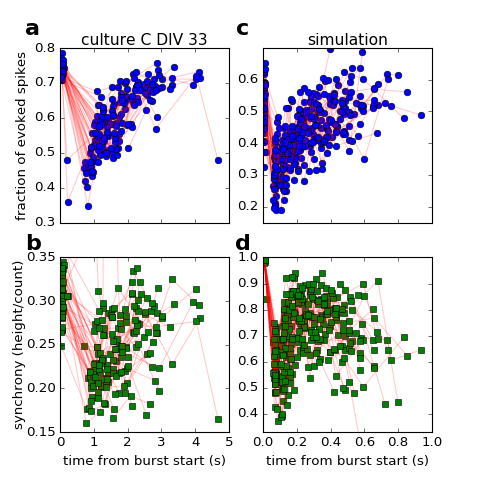

In [85]:
f,((a1,a2),(a3,a4)) = plt.subplots(2,2,sharex='col',figsize=(6,6))
f.subplots_adjust(hspace=0.2,wspace=0.2)
for xs,ys,_ in zip(*dExp['allp']):
    a1.plot(xs,ys,'-o',color=(1,0,0,0.2),markerfacecolor=(0,0,1,1))
a1.set_ylabel('fraction of evoked spikes')
a1.set_title('a',position=(-0.16,1.04),fontsize=20,fontweight='bold')
for xs,_,ys in zip(*dExp['allp']):
    a3.plot(xs,ys,'-s',color=(1,0,0,0.2),markerfacecolor=(0,0.5,0,1))
a3.set_ylim([0.15,0.35])
a3.set_ylabel('synchrony (height/count)',labelpad=0)
a3.set_xlabel('time from burst start (s)')
a3.set_title('b',position=(-0.16,1.01),fontsize=20,fontweight='bold')

for xs,ys,_ in zip(*dSim['allp']):
    a2.plot(xs,ys,'-o',color=(1,0,0,0.2),markerfacecolor=(0,0,1,1))
a2.set_ylim([0.15,0.7])
a2.set_title('c',position=(-0.12,1.04),fontsize=20,fontweight='bold')
for xs,_,ys in zip(*dSim['allp']):
    a4.plot(xs,ys,'-s',color=(1,0,0,0.2),markerfacecolor=(0,0.5,0,1))
a4.set_ylim([0.33,1.0])
a4.set_xlabel('time from burst start (s)')
a4.set_title('d',position=(-0.12,1.01),fontsize=20,fontweight='bold')
a1.text(2.5,0.8,'culture C DIV 33',horizontalalignment='center',verticalalignment='bottom',size=14)
a2.text(0.5,0.7,'simulation',horizontalalignment='center',verticalalignment='bottom',size=14)
a1.patch.set_visible(False)
a2.patch.set_visible(False)
a3.patch.set_visible(False)
a4.patch.set_visible(False)
#plt.savefig('evoked_synchrony1.svg',transparent=True)
plt.show()

## peak scatter plot from simulation

In [86]:
# read all dump data
[vrt,vrV,vrW,vCa,vrY,vrZ,vrQ] = map(np.array,zip(*np.loadtxt('d_0X.dmp')))
vrt /= 1000
vrX = 1.0 - vrY - vrZ - vrQ
vrD = vrZ+vrQ

<IPython.core.display.Javascript object>


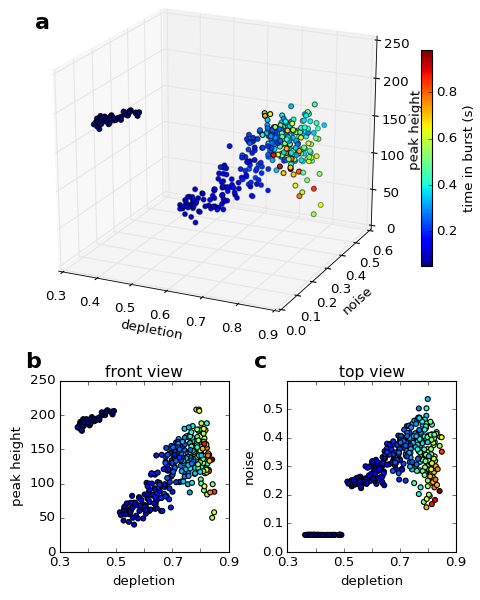

In [87]:
f = plt.figure(figsize=(6,7.5))
gs = gridspec.GridSpec(3,2,left=0.0,top=1.05,bottom=0.08)
ax = plt.subplot(gs[:2,:],projection='3d')
pkCs = []
pkDs = []
pkhs = []
pkns = []
clrs = []
for ib in range(len(bs)):
    i0,i1 = zoom_ib(ib)
    hst,cnt = su.slide_hist(spt[i0:i1],0.01)
    pkt,pkh,pks,pke = su.hst_peaks2(hst,cnt,epsilon=0.02)
    pkC = []
    pkD = []
    pkn = []
    l0 = 0
    j = i0
    for i in range(len(pkt)):
        pkC.append(vCa[int(pks[i]*1000)])
        pkD.append(vrD[int(pks[i]*1000)])
        while j<i1 and spt[j]<pks[i]: j+=1
        k=j
        while k<i1 and spt[k]<pke[i]: k+=1
        pkn.append(k-j)
    clr = pkt-bs[ib]
    pkCs = np.concatenate((pkCs,pkC))
    pkDs = np.concatenate((pkDs,pkD))
    pkhs = np.concatenate((pkhs,pkh))
    pkns = np.concatenate((pkns,pkn))
    clrs = np.concatenate((clrs,clr))
pcm = ax.scatter(pkDs,pkCs,pkhs,c=clrs)
ax.set_xlabel("depletion")
ax.set_ylabel("noise")
ax.set_zlabel("peak height")
cb = plt.colorbar(pcm,fraction=0.025,pad=-0.01,label='time in burst (s)',ticks=[0.2,0.4,0.6,0.8,1.0,1.2,1.4])
ax.view_init(elev=22,azim=-65)
ax.set_title('a',position=(0.1,0.9),fontsize=20,fontweight='bold')

gs = gridspec.GridSpec(3,2,top=1.05,bottom=0.08,right=0.95,wspace=0.35)
a1 = plt.subplot(gs[2,0])
a1.scatter(pkDs,pkhs,c=clrs)
a1.set_xlabel('depletion')
a1.set_ylabel('peak height')
a1.set_xlim([0.3,0.9])
a1.set_xticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9])
a1.set_xticklabels(['0.3','','0.5','','0.7','','0.9'])
a1.text(0.5,1.02,'front view',transform=a1.transAxes,horizontalalignment='center',fontsize=14)
a1.set_title('b',position=(-0.16,1.04),fontsize=20,fontweight='bold')



a2 = plt.subplot(gs[2,1])
a2.scatter(pkDs,pkCs,c=clrs)
a2.set_xlabel('depletion')
a2.set_xticklabels([])
a2.set_ylabel(r'noise')
a2.set_ylim([0.0,0.6])
a2.set_xlim([0.3,0.9])
a2.set_xticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9])
a2.set_xticklabels(['0.3','','0.5','','0.7','','0.9'])
a2.text(0.5,1.02,'top view',transform=a2.transAxes,horizontalalignment='center',fontsize=14)
a2.set_title('c',position=(-0.16,1.04),fontsize=20,fontweight='bold')

#plt.savefig('dep-noise-height4.svg',transparent=True)
plt.show()

In [88]:
ib = 27
i0,i1 = zoom_ib(ib)
hst,cnt = su.slide_hist(spt[i0:i1],0.01)
lvt,lvv,lvs = proprob(vopt,ib)
hstv,cntv = su.slide_hist([lvt[i] for i in range(len(lvv)) if lvv[i]>2.0],0.01)
pkt,pkh,pks,pke = su.hst_peaks2(hst,cnt,epsilon=0.02)
cnt = np.array(cnt)

<IPython.core.display.Javascript object>


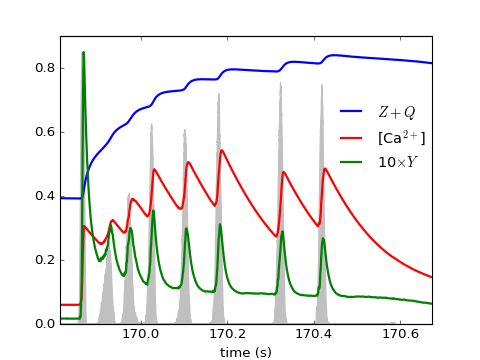

In [89]:
lt = 0.2
s0,s1 = find_range(vrt,bs[ib],dr[ib]+lt)
f,a = plt.subplots(figsize=(6,4.5))
a.fill_between(hst,cnt,color='#c0c0c0')
a.spines['left'].set_visible(False)
a.set_yticks([])
a2 = a.twinx()
a2.plot(vrt[s0:s1],vrD[s0:s1],'b',lw=2,label=r'$Z+Q$')
a2.plot(vrt[s0:s1],vCa[s0:s1],'r',lw=2,label='[Ca$^{2+}$]')
#a2 = a.twinx()
a2.plot(vrt[s0:s1],10*vrY[s0:s1],'g',lw=2,label=r'10$\times$$Y$')
#a2.plot(vrt[s0:s1],vrX[s0:s1],'g',lw=2,label=r'$X$')
a2.spines['right'].set_visible(False)
a2.spines['left'].set_visible(True)
a2.yaxis.set_label_position('left')
a2.yaxis.set_ticks_position('left')
a2.set_ylim([0,0.9])
a2.set_yticks([0,0.2,0.4,0.6,0.8])
a.set_xlim([bs[ib],dr[ib]+lt])
a.set_xticks([170.0,170.2,170.4,170.6])
a.ticklabel_format(useOffset=False)
plt.legend(loc='center right',frameon=False,bbox_to_anchor=(1.02,0.65),fontsize=13)
a.set_xlabel('time (s)')
a.patch.set_visible(False)
#plt.savefig('mean_over_burst1.svg')
plt.show()

## Raster plots

In [90]:
spt,spe = load_spk('C33.spk')

<IPython.core.display.Javascript object>


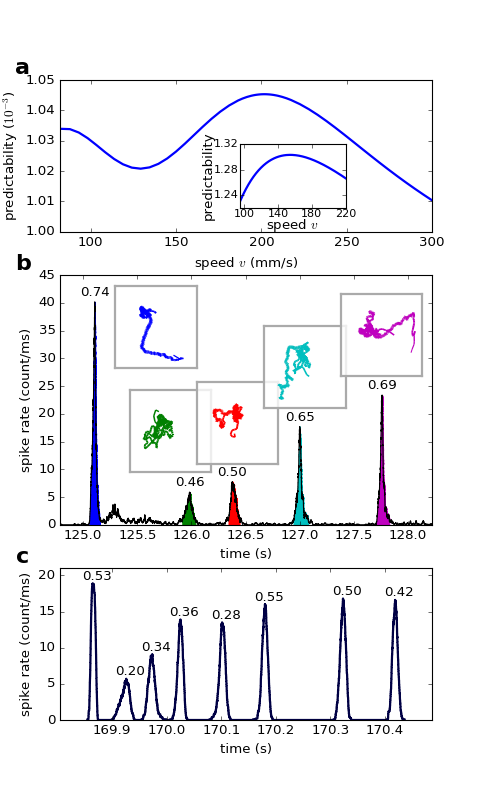

In [92]:
f = plt.figure(figsize=(6,10))
gs = gridspec.GridSpec(7,1)
gs.update(hspace=0.8)
# predictability vs V
a = plt.subplot(gs[:2,0])
[xs,ys] = dExp['predV']
xs = xs * 81/1000 # convert to mm/s
ys = ys * 1000
s0,s1 = find_range(xs,80,300)
a.plot(xs[s0:s1+1],ys[s0:s1+1],lw=2)
a.set_xlim([82,300])
a.set_ylim([1,1.05])
a.set_ylabel(r'predictability ($10^{-3}$)')
a.set_xlabel(r'speed $v$ (mm/s)')
a.set_title('a',position=(-0.1,1),fontsize=20,fontweight='bold')
a.patch.set_visible(False)

# inset for simulated predictability vs V
[xs,ys] = dSim['predV']
a = f.add_axes([0.5,0.74,0.22,0.08])
s0,s1 = find_range(xs,95,230)
a.plot(xs[s0:s1],ys[s0:s1],lw=2)
a.set_xlim([95,220])
a.set_ylim([1.22,1.32])
a.set_xticks([100,140,180,220])
a.set_yticks([1.24,1.28,1.32])
a.tick_params(pad=1,labelsize=10)
a.set_ylabel(r'predictability',labelpad=-1)
a.set_xlabel(r'speed $v$',labelpad=-2)

# histogram
a = plt.subplot(gs[2:5,0])
xs,ys = dExp['hstt']
a.plot(xs,ys,color='k',lw=1)
a.set_xlim([xs[0],xs[-1]])
a.set_ylabel(r'spike rate (count/ms)')
a.set_xlabel('time (s)')
a.set_title('b',position=(-0.1,1),fontsize=20,fontweight='bold')
a.patch.set_visible(False)

crts = [x['color'] for x in mpl.rcParamsDefault['axes.prop_cycle']] # color table
# color and label the peaks
s = 0
for j0,j1,tt,cc,ps in dExp['hpks']:
    a.fill_between(xs[j0:j1],ys[j0:j1],color=crts[s%7])
    a.text(ps[0],ps[1]/10+1,r"%.2f"%(cc/tt),size=12,horizontalalignment='center')
    s += 1

# CAT insets
lcs = []
s = 0
for sgms,lwds in pcats:
    lcs.append(LineCollection(sgms,color=crts[s%7],linewidths=lwds))
    s += 1
ctls = [(0.24,0.54),(0.27,0.41),(0.41,0.42),(0.55,0.49),(0.71,0.53)]
for i in range(len(lcs)):
    a = f.add_axes(list(ctls[i]+(0.17,0.17*6/10)))
    a.add_collection(lcs[i])
    a.set_xlim(0,63)
    a.set_ylim(0,63)
    a.set_xticks([])
    a.set_yticks([])
    for s in a.spines.values():
        s.set_color('#aaaaaa')
        s.set_linewidth(2)
    a.patch.set_alpha(0.8)

# simulated histogram

a = plt.subplot(gs[5:,0])
xs,ys = dSim['hstt']
a.plot(xs,ys,color='#000044',lw=2)

a.set_xlim([xs[0]-0.05,xs[-1]+0.05])
a.set_ylim([0,21])
a.set_xlabel('time (s)')
a.set_ylabel('spike rate (count/ms)')
a.set_title('c',position=(-0.1,1),fontsize=20,fontweight='bold')
a.patch.set_visible(False)
a.ticklabel_format(useOffset=False)

# label the peaks
s = 0
for j0,j1,tt,cc,ps in dSim['hpks']:
    a.text(ps[0]-0.02,ps[1]/10+0.5,r"%.2f"%(cc/tt),size=12)
    s += 1
#plt.savefig('predict_hists4.svg')
plt.show()